# Entrega final tarea 1: Programación dinámica

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid_world import GridWorld
from utils import display_policy
from utils import display_value_function

# Pregunta 1

***Programe el algoritmo “value iteration” para resolver el problema propuesto. Esta vez complete la
función run value iteration del archivo value iteration.py.***

In [2]:
action_dictionary={"0":"up","1":"down","2":"right","3":"left"}
action_dictionary

{'0': 'up', '1': 'down', '2': 'right', '3': 'left'}

**Funciones auxiliares**

In [3]:
# Función para sumar arreglos (x,y)
def sum_array(arreglo1, arreglo2):
    resultado = ()
    for elemento1, elemento2 in zip(arreglo1, arreglo2):
        suma = elemento1 + elemento2
        resultado += (suma,)
    return resultado

# Función para definir el siguiente estado dado la acción
def new_state(initial_state,action,reward_grid):

     # 0: subir, 1: bajar
    if (action==0) or (action==1):
    
        # Según la acción se define el delta state que permite obtener el nuevo potencial estado
        delta_state=(-1,0) if action==0 else (1,0)

        # Se obtiene el nuevo potencial estado mediante suma vectorial
        potential_new_state=sum_array(initial_state, delta_state)

    # 2: derecha,3: izquierda
    if (action==2) or (action==3):

        # Según la acción se define el delta state que permite obtener el nuevo potencial estado
        delta_state=(0,1) if  action==2  else  (0,-1)

        # Se obtiene el nuevo potencial estado mediante suma vectorial 
        potential_new_state=sum_array(initial_state, delta_state)

    # Permanecemos en el estado inicial si es que no se puede recorrer dicho estado sino, vamos al nuevo estado
    final_state=potential_new_state if ~np.isnan(reward_grid[potential_new_state]) else initial_state

    return final_state

# Función que retorna el reward asociado al estado actual
def Reward(initial_state,reward_grid):
    
    return reward_grid[initial_state] 

# Entrega acciones ortogonales a la entregada
def ortogonal_movements(action):

     if (action==0) or (action==1):
          
          # vertical 1
          x=2
          # vertical 2
          y=3
          return (x,y)
      
     if (action==2) or (action==3):
          
          # vertical 1
          x=0
          # vertical 2
          y=1
          return (x,y)     

**Policy iterator**

In [6]:
class PolicyIterator():
    
    def __init__(self, reward_grid, wall_value, cell_value, terminal_value):

        self._reward_grid = reward_grid
        self._wall_value = wall_value
        self._cell_value = cell_value
        self._terminal_value = terminal_value

        self._value_function = np.zeros(self._reward_grid.shape)
        self._value_function *= self._reward_grid
        self._policy = self._value_function.copy()


    def _policy_evaluation(self, nb_iters, p_dir, gamma, v_thresh):
        
        # Policy evaluation
        # Code your algorithm here (P1-2) (you can add auxiliary functions if needed)
        p_random    = 1 - p_dir
        #p_side
        value_rows, value_cols = self._value_function.shape

        # Inicializar delta
        delta=0

        num_update_value_function=0

        for _ in range(nb_iters):

            # Inicializar delta
            delta=0
            
            # Indexes for skipping external walls (you may change them)
            for j in range(1, value_rows - 1):
                for i in range(1, value_cols - 1):

                    if self._reward_grid[(j,i)]==self._cell_value:
                        
                        # Estado inicial
                        actual_state=(j,i)

                        # Función de valor Vs antiguo
                        old_value=self._value_function[actual_state]

                        # Politica estado actual
                        old_action=self._policy[actual_state]

                        reward=Reward(actual_state,self._reward_grid)

                        # Movimientos ortogonales
                        x,y=ortogonal_movements(old_action)

                        # Estado dir
                        state_dir=new_state(actual_state,old_action,self._reward_grid)

                        # estado ortogonal 1
                        state_x=new_state(actual_state,x,self._reward_grid)

                        # Estado ortogonal 2
                        state_y=new_state(actual_state,y,self._reward_grid)

                        # Value functions next potential states: Vs'
                        Vs_dir=self._value_function[state_dir]
                        Vs_x=self._value_function[state_x]
                        Vs_y=self._value_function[state_y]
                        
                        new_value=p_dir*(reward+gamma*Vs_dir)+p_random*0.5*(reward+gamma*Vs_x)+p_random*0.5*(reward+gamma*Vs_y)

                        self._value_function[actual_state]=new_value
            
                        delta=max(delta,abs(old_value-new_value))

                        #print(delta)

            num_update_value_function+=1
            
            if delta < v_thresh:
                print("# de actualizaciones a función de valor: ",num_update_value_function)
                break
                            
    def _policy_improvement(self, nb_iters, p_dir, gamma):

        # Policy improvement
        # Code your algorithm here (P1-2) (you can add auxiliary functions if needed)
        p_random    = 1 - p_dir
        value_rows, value_cols = self._value_function.shape
        stable_policy = True
        
        for j in range(1, value_rows - 1):
            for i in range(1, value_cols - 1):
            
                if self._reward_grid[(j,i)]==self._cell_value:
                    
                    # Estado inicial
                    actual_state=(j,i)

                    # Politica estado actual
                    old_action=self._policy[actual_state]

                    reward=Reward(actual_state,self._reward_grid)

                    list_values=[]
                    for action in range(4):

                        # Movimientos ortogonales
                        x,y=ortogonal_movements(action)

                        # Estado dir
                        state_dir=new_state(actual_state,action,self._reward_grid)

                        # estado ortogonal 1
                        state_x=new_state(actual_state,x,self._reward_grid)

                        # Estado ortogonal 2
                        state_y=new_state(actual_state,y,self._reward_grid)

                        # Value functions next potential states: Vs'
                        Vs_dir=self._value_function[state_dir]
                        Vs_x=self._value_function[state_x]
                        Vs_y=self._value_function[state_y]
                        
                        new_value=p_dir*(reward+gamma*Vs_dir)+p_random*0.5*(reward+gamma*Vs_x)+p_random*0.5*(reward+gamma*Vs_y)

                        list_values.append(new_value)
                    
                    new_action=np.array(list_values).argmax()
                    
                    # Update nueva mejor acción
                    self._policy[actual_state]=new_action

                    if new_action!=old_action:
                            stable_policy=False

                
        return stable_policy


    def run_policy_iteration(self, p_dir, nb_iters, gamma, v_thresh):
        stable_policy = False

        policy_count=0

        while not stable_policy:
            self._policy_evaluation(nb_iters, p_dir, gamma, v_thresh)
            policy_count+=1
            stable_policy = self._policy_improvement(nb_iters, p_dir, gamma) 
                   
        print("# Llamados a función policy evaluation: ", policy_count)

**Value iterator**

In [7]:
class ValueIterator():

    def __init__(self, reward_grid, wall_value, cell_value, terminal_value):

        self._reward_grid = reward_grid
        self._wall_value = wall_value
        self._cell_value = cell_value
        self._terminal_value = terminal_value

        self._value_function = np.zeros(self._reward_grid.shape)
        self._value_function *= self._reward_grid
        self._policy = self._value_function.copy()


    def run_value_iteration(self, p_dir, nb_iters, gamma, v_thresh):

        p_random    = 1 - p_dir
        #p_side
        value_rows, value_cols = self._value_function.shape

        # V(s) = max_a sum_s'(P_ss'^a[R_ss'^a+gamma*V(s')]) 
        # We perform all posible actions, check the value, and update according to the max value found
        
        num_update_value_function=0

        # Inicializar delta
        delta=0
        
        for _ in range(nb_iters):

            # Inicializar delta
            delta=0
            
            # Indexes for skipping external walls (you may change them)
            for j in range(1, value_rows - 1):
                for i in range(1, value_cols - 1):

                    if self._reward_grid[(j,i)]==self._cell_value:
                        
                        # Estado inicial
                        actual_state=(j,i)

                        # Función de valor Vs antiguo
                        old_value=self._value_function[actual_state]

                        # Max function value to an specific action
                        list_values=[]
                        for action in range(4):

                            # Reward
                            reward=Reward(actual_state,self._reward_grid)

                            # Movimientos ortogonales
                            x,y=ortogonal_movements(action)

                            # Estado dir
                            state_dir=new_state(actual_state,action,self._reward_grid)

                            # estado ortogonal 1
                            state_x=new_state(actual_state,x,self._reward_grid)

                            # Estado ortogonal 2
                            state_y=new_state(actual_state,y,self._reward_grid)

                            # Value functions next potential states: Vs'
                            Vs_dir=self._value_function[state_dir]
                            Vs_x=self._value_function[state_x]
                            Vs_y=self._value_function[state_y]
                            
                            new_value=p_dir*(reward+gamma*Vs_dir)+p_random*0.5*(reward+gamma*Vs_x)+p_random*0.5*(reward+gamma*Vs_y)

                            list_values.append(new_value)
                        
                        # Best action
                        new_action=np.array(list_values).argmax()

                        # Max value
                        new_max_value=np.array(list_values).max()

                        # Update nueva mejor acción
                        self._policy[actual_state]=new_action

                        # Update max value
                        self._value_function[actual_state]=new_max_value
                    
                        # delta value function
                        delta=max(delta,abs(old_value-new_max_value))
                        #print(delta)
                           
            num_update_value_function+=1
    
            if delta < v_thresh:
                print("# de actualizaciones a función de valor: ",num_update_value_function)
                break  

# Pregunta 2

# de actualizaciones a función de valor:  36


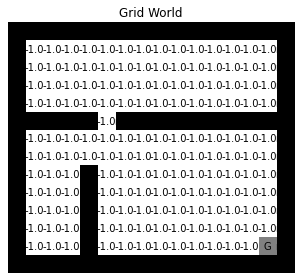

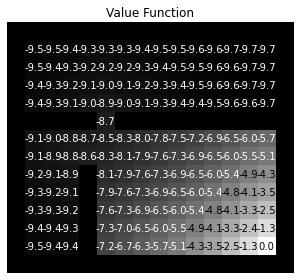

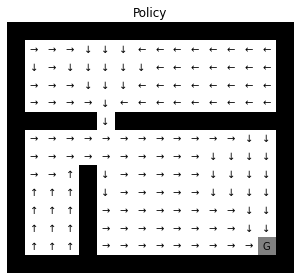

In [8]:
world = GridWorld(height=14, width=16)

value_iterator = ValueIterator(reward_grid=world._rewards,
                                wall_value=None,
                                cell_value=-1,
                                terminal_value=0)

# Default parameters for P2-2 (change them for P2-3 & P2-4 & P2-5)
value_iterator.run_value_iteration(p_dir=0.8,
                                    nb_iters=1000,
                                    gamma=0.9,
                                    #v_thresh=0.2
                                    v_thresh=0.0001
                                     )

world.display()

display_value_function(value_iterator._value_function)

display_policy(world._grid,
                value_iterator._reward_grid,
                value_iterator._policy)

plt.show()

# Pregunta 3

**1-p=0**

**Policy_iteration**

# de actualizaciones a función de valor:  89
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  3
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  3
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función de valor:  2
# de actualizaciones a función 

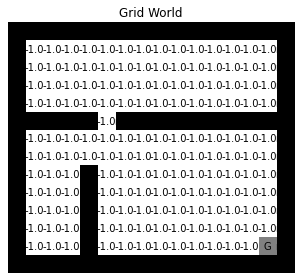

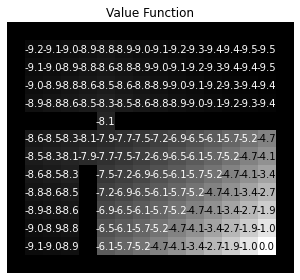

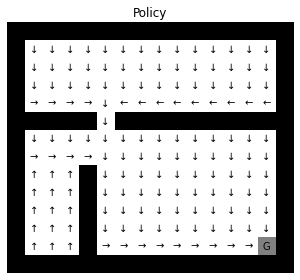

In [16]:

world = GridWorld(height=14, width=16)
policy_iterator = PolicyIterator(reward_grid=world._rewards,
                                    wall_value=None,
                                    cell_value=-1,
                                    terminal_value=0)

# Default parameters for P1-3 (change them for P2-3)
policy_iterator.run_policy_iteration(p_dir=1,
                                        nb_iters=1000,
                                        gamma=0.9,
                                        v_thresh=0.0001)

world.display()

display_value_function(policy_iterator._value_function)

display_policy(world._grid,
                policy_iterator._reward_grid,
                policy_iterator._policy)

plt.show()

**Value_iteration**

# de actualizaciones a función de valor:  30


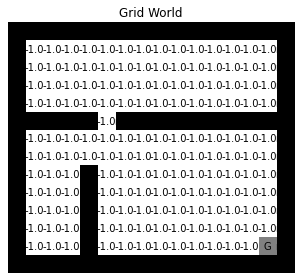

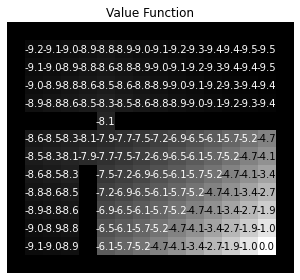

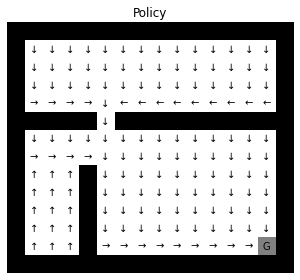

In [10]:
world = GridWorld(height=14, width=16)

value_iterator = ValueIterator(reward_grid=world._rewards,
                                wall_value=None,
                                cell_value=-1,
                                terminal_value=0)

# Default parameters for P2-2 (change them for P2-3 & P2-4 & P2-5)
value_iterator.run_value_iteration(p_dir=1,
                                    nb_iters=1000,
                                    gamma=0.9,
                                    v_thresh=0.0001)

world.display()

display_value_function(value_iterator._value_function)

display_policy(world._grid,
                value_iterator._reward_grid,
                value_iterator._policy)

plt.show()

# Pregunta 4

**1-p=0.4 & gamma=0.2**

# de actualizaciones a función de valor:  7


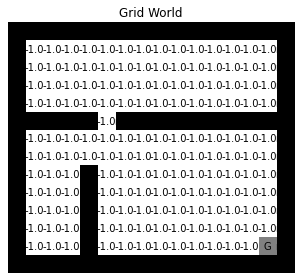

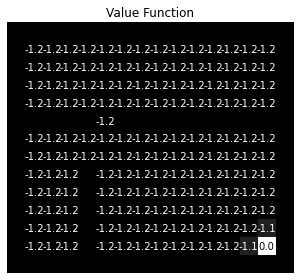

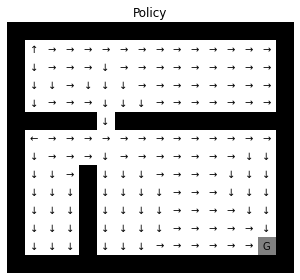

In [12]:
world = GridWorld(height=14, width=16)

value_iterator = ValueIterator(reward_grid=world._rewards,
                                wall_value=None,
                                cell_value=-1,
                                terminal_value=0)

# Default parameters for P2-2 (change them for P2-3 & P2-4 & P2-5)
value_iterator.run_value_iteration(p_dir=0.6,
                                    nb_iters=1000,
                                    gamma=0.2,
                                    v_thresh=0.0001)

world.display()

display_value_function(value_iterator._value_function)

display_policy(world._grid,
                value_iterator._reward_grid,
                value_iterator._policy)

plt.show()

**1-p=0.4 & gamma=1**

# de actualizaciones a función de valor:  64


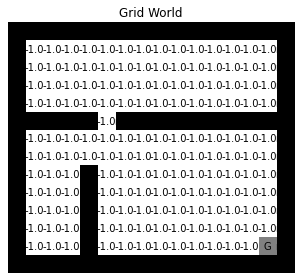

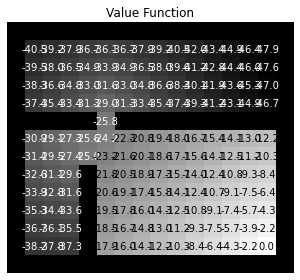

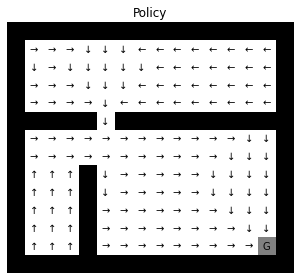

In [14]:
world = GridWorld(height=14, width=16)

value_iterator = ValueIterator(reward_grid=world._rewards,
                                wall_value=None,
                                cell_value=-1,
                                terminal_value=0)

# Default parameters for P2-2 (change them for P2-3 & P2-4 & P2-5)
value_iterator.run_value_iteration(p_dir=0.6,
                                    nb_iters=1000,
                                    gamma=1,
                                    v_thresh=0.0001)

world.display()

display_value_function(value_iterator._value_function)

display_policy(world._grid,
                value_iterator._reward_grid,
                value_iterator._policy)

plt.show()